In [1]:
from __future__ import annotations

from typing import Union, Tuple

import pandas as pd
import numpy as np

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.power import tt_ind_solve_power

from tqdm import tqdm, trange

from matplotlib import pyplot as plt
import seaborn as sns

These functions define how Tb.N and Tb.BV/TV will be computed from Tb.Th and Tb.Sp in the rest of the notebook. Here we assume the hypothesized relationship for Tb.N, but for Tb.BV/TV we use the power-law with the coefficients fitted to the Measured data from the other notebook. As always the exact values are not so important here, and we would draw the same broad conclusions about statistical testing and study design if we set the specific coefficients for Tb.BV/TV to other (reasonable) values.

In [2]:
def calculate_tbn(
    tbth: Union[float, np.ndarray], 
    tbsp: Union[float, np.ndarray]
) -> Union[float, np.ndarray]:
    return 1 / (tbth + tbsp)

def calculate_tbbvtv(
    tbth: Union[float, np.ndarray], 
    tbsp: Union[float, np.ndarray],
    a: float = 1.30,
    alpha: float = 1.27
) -> Union[float, np.ndarray]:
    return a * (tbth / (tbth + tbsp))**alpha

Start by defining some parameters for the synthetic experiments and computing the required sample size to achieve the specified power with the specified significance threshold and efect size.

In [3]:
plot_width = 3

trials = 10000

alpha = 0.05
power = 0.8
ratio = 1.0
effect_size = 0.5 # this is standardized effect size: (u1 - u2) / sigma

N = np.ceil(tt_ind_solve_power(
    effect_size=effect_size, 
    nobs1=None, 
    alpha=alpha, 
    power=power, 
    ratio=ratio, 
    alternative='two-sided'
)).astype(int)

print(
    f"We need {N} observations to achieve a type I error rate of {alpha:0.2f}"
    f" and a type II error rate of {1-power:0.2f} with \n"
    f"a standardized effect size of {effect_size:0.2f} and a ratio of {ratio:0.2f}."
)

We need 64 observations to achieve a type I error rate of 0.05 and a type II error rate of 0.20 with 
a standardized effect size of 0.50 and a ratio of 1.00.


We're going to assume that our variables come from a Gamma distribution and calculate the shape and scale parameters for a given prescribed mean and standard deviation (with and without the effect). Trabecular thickness and separation can't be <= 0 so this is a bit more realistic than just drawing from a normal distribution, and it is particularly important to make sure that the derived Tb.BV/TV and Tb.N values are realistic.

The base mean and standard deviations are taken from the "Measured" data reported in the other notebook in this repository.

In [4]:
def calculate_shape_and_scale(
    mean: float, standard_deviation: float, effect_size: float
) -> Tuple[float, float]:
    shape = ((mean + effect_size * standard_deviation) / standard_deviation) ** 2
    scale = (standard_deviation ** 2) / (mean + effect_size * standard_deviation)
    return shape, scale


tbth_base_mean = 0.25
tbth_standard_deviation = 0.03

tbsp_base_mean = 0.75
tbsp_standard_deviation = 0.27

k_tbth_null, theta_tbth_null = calculate_shape_and_scale(tbth_base_mean, tbth_standard_deviation, 0) 
k_tbsp_null, theta_tbsp_null = calculate_shape_and_scale(tbth_base_mean, tbth_standard_deviation, 0)  

k_tbth_effect, theta_tbth_effect = calculate_shape_and_scale(tbth_base_mean, tbth_standard_deviation, effect_size) 
k_tbsp_effect, theta_tbsp_effect = calculate_shape_and_scale(tbth_base_mean, tbth_standard_deviation, effect_size) 

Prepare a dataframe to store the results of these experiments in:

In [5]:
errors = pd.DataFrame.from_dict({
    "Variables": [
        "Tb.Th", 
        "Tb.Th, Tb.Sp", 
        "Tb.Th, Tb.Sp", 
        "Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV", 
        "Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV"
    ],
    "FDR Control?": [False, False, True, False, True],
    "Type I Error Rate": [0, 0, 0, 0, 0],
    "Type II Error Rate": [0, 0, 0, 0, 0]
})

errors

,Variables,FDR Control?,Type I Error Rate,Type II Error Rate
0,Tb.Th,False,0,0
1,"Tb.Th, Tb.Sp",False,0,0
2,"Tb.Th, Tb.Sp",True,0,0
3,"Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV",False,0,0
4,"Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV",True,0,0


First we generate data where the two groups are identical and where we test only a single variable, to check the type I error rate.

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4091.54it/s]


We have a significance threshold of 0.050 and expect this to be the type I error rate. 
The type I error rate was 0.046.


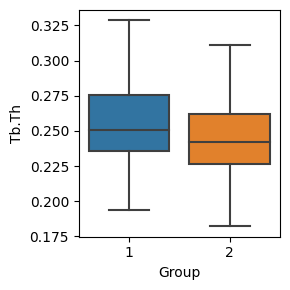

In [6]:
type_1_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    t, p = ttest_ind(tbth_group1, tbth_group2)
    
    type_1_errors += (p < alpha)


errors.loc[errors["Variables"]=="Tb.Th", "Type I Error Rate"] = type_1_errors / trials
    
print(
    f"We have a significance threshold of {alpha:0.3f} and expect this to be the type I error rate. \n"
    f"The type I error rate was {(type_1_errors / trials):0.3f}."
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2])
})


plt.figure(figsize=(plot_width, plot_width))

sns.boxplot(data=df, x="Group", y="Tb.Th")

plt.tight_layout()
plt.show()

Now let's repeat this, but with two independent variables, with and without false discovery rate correction:

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1834.46it/s]


We have a significance threshold of 0.050 and expect this to be the type I error rate. 
Without FDR, the type I error rate was 0.097. 
With FDR, the type I error rate was 0.049. 



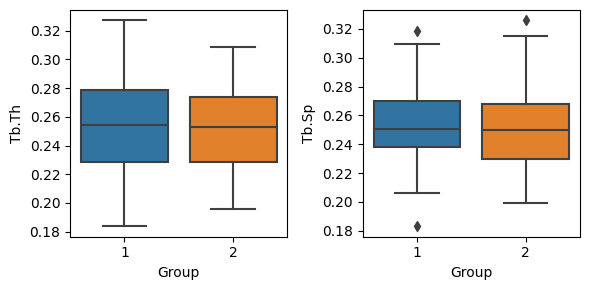

In [7]:
uncontrolled_type_1_errors = 0
controlled_type_1_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_t, tbth_p = ttest_ind(tbth_group1, tbth_group2)
    
    tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_group2 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_t, tbsp_p = ttest_ind(tbsp_group1, tbsp_group2)
    
    uncontrolled_type_1_errors += ((tbth_p < alpha) | (tbsp_p < alpha))
    
    rejected, _ = fdrcorrection([tbth_p, tbsp_p], alpha=alpha, method="indep")
    
    controlled_type_1_errors += any(rejected)
    

errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp") & (errors["FDR Control?"]==False), 
    "Type I Error Rate"
] = uncontrolled_type_1_errors / trials
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp") & (errors["FDR Control?"]==True), 
    "Type I Error Rate"
] = controlled_type_1_errors / trials
    
print(
    f"We have a significance threshold of {alpha:0.3f} and expect this to be the type I error rate. \n"
    f"Without FDR, the type I error rate was {(uncontrolled_type_1_errors / trials):0.3f}. \n"
    f"With FDR, the type I error rate was {(controlled_type_1_errors / trials):0.3f}. \n"
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2]),
    "Tb.Sp": np.concatenate([tbsp_group1, tbsp_group2])
})


fig, axs = plt.subplots(1,2,figsize=(2*plot_width, plot_width))

sns.boxplot(ax=axs[0], data=df, x="Group", y="Tb.Th")
sns.boxplot(ax=axs[1], data=df, x="Group", y="Tb.Sp")

plt.tight_layout()
plt.show()

Finally, repeat one more time but this time with two independent variables and then two additional variables that derive from the first two:

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1028.93it/s]


We have a significance threshold of 0.050 and expect this to be the type I error rate. 
Without FDR control, the type I error rate was 0.132. 
With FDR control, the type I error rate was 0.042. 



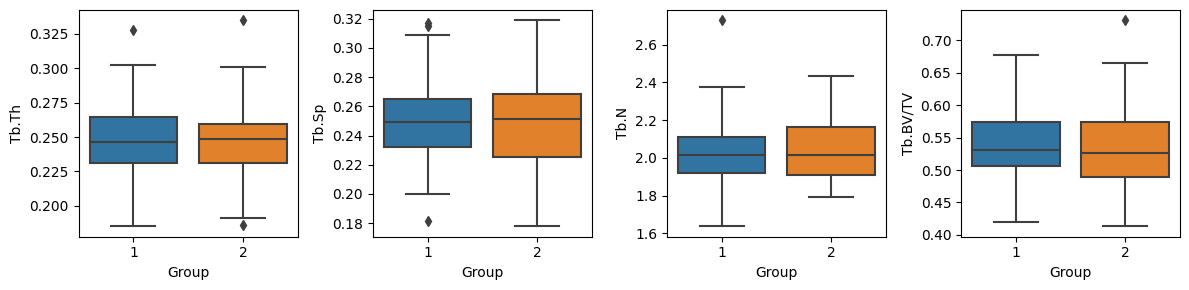

In [8]:
uncontrolled_type_1_errors = 0
controlled_type_1_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_t, tbth_p = ttest_ind(tbth_group1, tbth_group2)
    
    tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_group2 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_t, tbsp_p = ttest_ind(tbsp_group1, tbsp_group2)
    
    tbn_group1 = calculate_tbn(tbth_group1, tbsp_group1)
    tbn_group2 = calculate_tbn(tbth_group2, tbsp_group2)
    tbn_t, tbn_p = ttest_ind(tbn_group1, tbn_group2)
    
    tbbvtv_group1 = calculate_tbbvtv(tbth_group1, tbsp_group1)
    tbbvtv_group2 = calculate_tbbvtv(tbth_group2, tbsp_group2)
    tbbvtv_t, tbbvtv_p = ttest_ind(tbbvtv_group1, tbbvtv_group2)
    
    uncontrolled_type_1_errors += (
        (tbth_p < alpha) 
        | (tbsp_p < alpha) 
        | (tbn_p < alpha) 
        | (tbbvtv_p < alpha)
    )
    
    rejected, _ = fdrcorrection(
        [tbth_p, tbsp_p, tbn_p, tbbvtv_p], 
        alpha=alpha, method="indep"
    )
    
    controlled_type_1_errors += any(rejected)
    
    
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV") & (errors["FDR Control?"]==False), 
    "Type I Error Rate"
] = uncontrolled_type_1_errors / trials
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV") & (errors["FDR Control?"]==True), 
    "Type I Error Rate"
] = controlled_type_1_errors / trials


print(
    f"We have a significance threshold of {alpha:0.3f} and expect this to be the type I error rate. \n"
    f"Without FDR control, the type I error rate was {(uncontrolled_type_1_errors / trials):0.3f}. \n"
    f"With FDR control, the type I error rate was {(controlled_type_1_errors / trials):0.3f}. \n"
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2]),
    "Tb.Sp": np.concatenate([tbsp_group1, tbsp_group2]),
    "Tb.N": np.concatenate([tbn_group1, tbn_group2]),
    "Tb.BV/TV": np.concatenate([tbbvtv_group1, tbbvtv_group2])
})


fig, axs = plt.subplots(1,4,figsize=(4*plot_width, plot_width))

sns.boxplot(ax=axs[0], data=df, x="Group", y="Tb.Th")
sns.boxplot(ax=axs[1], data=df, x="Group", y="Tb.Sp")
sns.boxplot(ax=axs[2], data=df, x="Group", y="Tb.N")
sns.boxplot(ax=axs[3], data=df, x="Group", y="Tb.BV/TV")

plt.tight_layout()
plt.show()

Now let's turn to the type II error rate.

In the following experiments, we will generate fake datasets that do have the anticipated effect and see how often we correctly reject the null.

First, the single-variable case:

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4090.25it/s]


We have a power of 0.800 and expect a type II error rate of 0.200. 
The type II error rate was 0.201


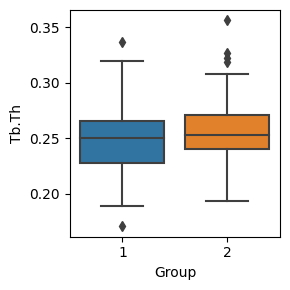

In [9]:
type_2_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_effect, scale=theta_tbth_effect, size=(N,))
    tbth_t, tbth_p = ttest_ind(tbth_group1, tbth_group2)
    
    type_2_errors += (tbth_p > alpha)


errors.loc[errors["Variables"]=="Tb.Th", "Type II Error Rate"] = type_2_errors / trials
    
print(
    f"We have a power of {power:0.3f} and expect a type II error rate of {(1 - power):0.3f}. \n"
    f"The type II error rate was {(type_2_errors / trials):0.3f}"
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2])
})


plt.figure(figsize=(plot_width, plot_width))

sns.boxplot(data=df, x="Group", y="Tb.Th")

plt.tight_layout()
plt.show()

Repeat for two variables, with and without false discovery rate correction:

100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1758.11it/s]


We have a power of 0.800 and expect a type II error rate of 0.200. 
Without FDR control, the type II error rate was 0.199. 
With FDR control, the type II error rate was 0.217. 



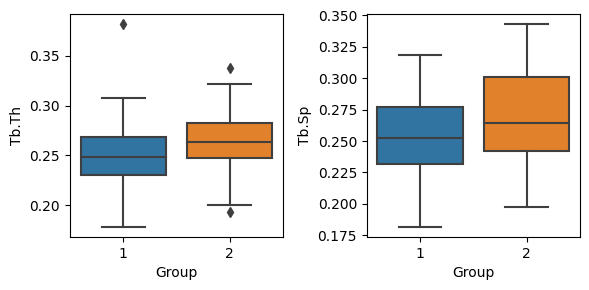

In [10]:
uncontrolled_type_2_errors = 0
controlled_type_2_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_effect, scale=theta_tbth_effect, size=(N,))
    tbth_t, tbth_p = ttest_ind(tbth_group1, tbth_group2)
    
    tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_group2 = np.random.gamma(shape=k_tbsp_effect, scale=theta_tbsp_effect, size=(N,))
    tbsp_t, tbsp_p = ttest_ind(tbsp_group1, tbsp_group2)
    
    uncontrolled_type_2_errors += (tbth_p > alpha)
    uncontrolled_type_2_errors += (tbsp_p > alpha)
    
    rejected, _ = fdrcorrection([tbth_p, tbsp_p], alpha=alpha, method="indep")
    
    controlled_type_2_errors += (~rejected).sum()
    
    
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp") & (errors["FDR Control?"]==False), 
    "Type II Error Rate"
] = uncontrolled_type_2_errors / (2 * trials)
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp") & (errors["FDR Control?"]==True), 
    "Type II Error Rate"
] = controlled_type_2_errors / (2 * trials)

    
print(
    f"We have a power of {power:0.3f} and expect a type II error rate of {(1 - power):0.3f}. \n"
    f"Without FDR control, the type II error rate was {(uncontrolled_type_2_errors / (2*trials)):0.3f}. \n"
    f"With FDR control, the type II error rate was {(controlled_type_2_errors / (2*trials)):0.3f}. \n"
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2]),
    "Tb.Sp": np.concatenate([tbsp_group1, tbsp_group2])
})

fig, axs = plt.subplots(1,2,figsize=(2*plot_width, plot_width))

sns.boxplot(ax=axs[0], data=df, x="Group", y="Tb.Th")
sns.boxplot(ax=axs[1], data=df, x="Group", y="Tb.Sp")

plt.tight_layout()
plt.show()

And repeat a third time, now with the additional two variables that depend on the first two but that we naively treat as independent for our testing.

100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 966.28it/s]


We have a power of 0.800 and expect a type II error rate of 0.200. 
Without FDR control, the type II error rate was 0.200. 
With FDR control, the type II error rate was 0.251. 



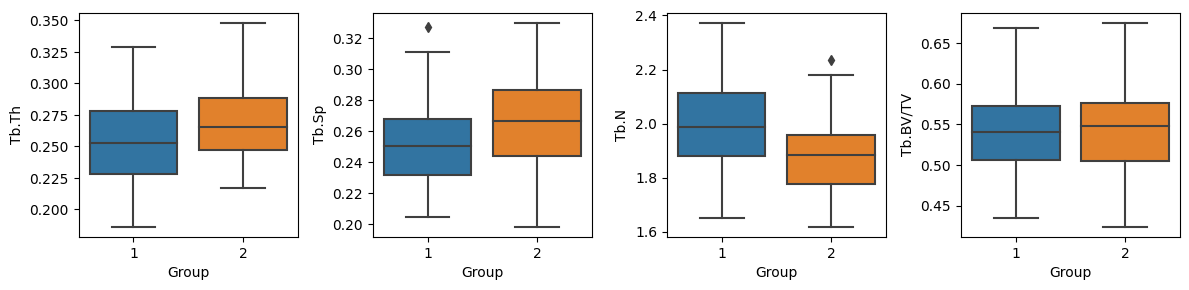

In [11]:
uncontrolled_type_2_errors = 0
controlled_type_2_errors = 0

for _ in trange(trials):

    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(N,))
    tbth_group2 = np.random.gamma(shape=k_tbth_effect, scale=theta_tbth_effect, size=(N,))
    tbth_t, tbth_p = ttest_ind(tbth_group1, tbth_group2)
    
    tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(N,))
    tbsp_group2 = np.random.gamma(shape=k_tbsp_effect, scale=theta_tbsp_effect, size=(N,))
    tbsp_t, tbsp_p = ttest_ind(tbsp_group1, tbsp_group2)
    
    tbn_group1 = calculate_tbn(tbth_group1, tbsp_group1)
    tbn_group2 = calculate_tbn(tbth_group2, tbsp_group2)
    tbn_t, tbn_p = ttest_ind(tbn_group1, tbn_group2)
    
    tbbvtv_group1 = calculate_tbbvtv(tbth_group1, tbsp_group1)
    tbbvtv_group2 = calculate_tbbvtv(tbth_group2, tbsp_group2)
    tbbvtv_t, tbbvtv_p = ttest_ind(tbbvtv_group1, tbbvtv_group2)
    
    uncontrolled_type_2_errors += (tbth_p > alpha)
    uncontrolled_type_2_errors += (tbsp_p > alpha)
    #uncontrolled_type_2_errors += (tbn_p > alpha)
    #uncontrolled_type_2_errors += (tbbvtv_p > alpha)
    
    rejected, _ = fdrcorrection(
        [tbth_p, tbsp_p, tbn_p, tbbvtv_p], 
        alpha=alpha, method="indep"
    )
    
    controlled_type_2_errors += (~rejected[:2]).sum()
    
    
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV") & (errors["FDR Control?"]==False), 
    "Type II Error Rate"
] = uncontrolled_type_2_errors / (2*trials)
errors.loc[
    (errors["Variables"]=="Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV") & (errors["FDR Control?"]==True), 
    "Type II Error Rate"
] = controlled_type_2_errors / (2*trials)    
    
print(
    f"We have a power of {power:0.3f} and expect a type II error rate of {(1 - power):0.3f}. \n"
    f"Without FDR control, the type II error rate was {(uncontrolled_type_2_errors / (2 * trials)):0.3f}. \n"
    f"With FDR control, the type II error rate was {(controlled_type_2_errors / (2 * trials)):0.3f}. \n"
)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((N,)), 2*np.ones((N,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2]),
    "Tb.Sp": np.concatenate([tbsp_group1, tbsp_group2]),
    "Tb.N": np.concatenate([tbn_group1, tbn_group2]),
    "Tb.BV/TV": np.concatenate([tbbvtv_group1, tbbvtv_group2])
})

fig, axs = plt.subplots(1,4,figsize=(4*plot_width, plot_width))

sns.boxplot(ax=axs[0], data=df, x="Group", y="Tb.Th")
sns.boxplot(ax=axs[1], data=df, x="Group", y="Tb.Sp")
sns.boxplot(ax=axs[2], data=df, x="Group", y="Tb.N")
sns.boxplot(ax=axs[3], data=df, x="Group", y="Tb.BV/TV")

plt.tight_layout()
plt.show()

IMPORTANT NOTE: Here we have used only the statistical tests for Tb.Th and Tb.Sp to check the type II error rate. We selected the sample size based on an anticipated effect size for Tb.Th and Tb.Sp, but because Tb.N and Tb.BV/TV depend non-linearly on Tb.Th and Tb.Sp, we cannot expect the same effect size for these variables. In the cells below we explore how the effect size of Tb.Th and Tb.Sp will determine effect size of Tb.N and Tb.BV/TV.

In [12]:
def calculate_effect_size(x1: np.ndarray, x2: np.ndarray) -> float:
    raw_effect = x2.mean() - x1.mean()
    pooled_std = np.sqrt((x1.std()**2 + x2.std()**2)/2)
    return raw_effect / pooled_std

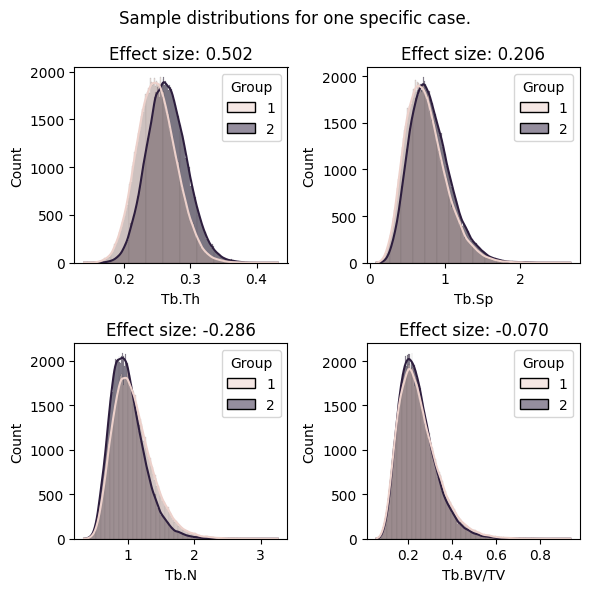

In [13]:
# PARAMETERS

M = 100000

tbth_base_mean = 0.25
tbth_standard_deviation = 0.03

tbsp_base_mean = 0.75
tbsp_standard_deviation = 0.27

tbth_effect_size = 0.5
tbsp_effect_size = 0.2

# CALCULATIONS

k_tbth_null = (tbth_base_mean / tbth_standard_deviation) ** 2
theta_tbth_null = (tbth_standard_deviation ** 2) / tbth_base_mean

k_tbsp_null = (tbsp_base_mean / tbsp_standard_deviation) ** 2
theta_tbsp_null = (tbsp_standard_deviation ** 2) / tbsp_base_mean


k_tbth_effect = ((tbth_base_mean + tbth_effect_size * tbth_standard_deviation) / tbth_standard_deviation) ** 2
theta_tbth_effect = (tbth_standard_deviation ** 2) / (tbth_base_mean + tbth_effect_size * tbth_standard_deviation)

k_tbsp_effect = ((tbsp_base_mean + tbsp_effect_size * tbsp_standard_deviation) / tbsp_standard_deviation) ** 2
theta_tbsp_effect = (tbsp_standard_deviation ** 2) / (tbsp_base_mean + tbsp_effect_size * tbsp_standard_deviation)


tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(M,))
tbth_group2 = np.random.gamma(shape=k_tbth_effect, scale=theta_tbth_effect, size=(M,))

tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(M,))
tbsp_group2 = np.random.gamma(shape=k_tbsp_effect, scale=theta_tbsp_effect, size=(M,))

tbn_group1 = calculate_tbn(tbth_group1, tbsp_group1)
tbn_group2 = calculate_tbn(tbth_group2, tbsp_group2)

tbbvtv_group1 = calculate_tbbvtv(tbth_group1, tbsp_group1)
tbbvtv_group2 = calculate_tbbvtv(tbth_group2, tbsp_group2)

df = pd.DataFrame.from_dict({
    "Group": np.concatenate([np.ones((M,)), 2*np.ones((M,))]).astype(int),
    "Tb.Th": np.concatenate([tbth_group1, tbth_group2]),
    "Tb.Sp": np.concatenate([tbsp_group1, tbsp_group2]),
    "Tb.N": np.concatenate([tbn_group1, tbn_group2]),
    "Tb.BV/TV": np.concatenate([tbbvtv_group1, tbbvtv_group2])
})

fig, axs = plt.subplots(2, 2, figsize=(2*plot_width, 2*plot_width))

sns.histplot(ax=axs[0][0], data=df, x="Tb.Th", hue="Group", kde=True)
sns.histplot(ax=axs[0][1], data=df, x="Tb.Sp", hue="Group", kde=True)
sns.histplot(ax=axs[1][0], data=df, x="Tb.N", hue="Group", kde=True)
sns.histplot(ax=axs[1][1], data=df, x="Tb.BV/TV", hue="Group", kde=True)

fig.suptitle("Sample distributions for one specific case.")
axs[0][0].set_title(f"Effect size: {calculate_effect_size(tbth_group1, tbth_group2):0.3f}")
axs[0][1].set_title(f"Effect size: {calculate_effect_size(tbsp_group1, tbsp_group2):0.3f}")
axs[1][0].set_title(f"Effect size: {calculate_effect_size(tbn_group1, tbn_group2):0.3f}")
axs[1][1].set_title(f"Effect size: {calculate_effect_size(tbbvtv_group1, tbbvtv_group2):0.3f}")

plt.tight_layout()
plt.show()

In the above cell, by adjusting the effect sizes for Tb.Th and Tb.Sp we can see how the distributions in Tb.N and Tb.BV/TV will be affected and what the expected effect sizes should be. In the below cell, we sweep over a space of possible effect sizes and generate a contour plot showing how the effect sizes of Tb.N and Tb.BV/TV vary with Tb.Th and Tb.Sp.

In [14]:
# PARAMETERS

M = 10000

tbth_base_mean = 0.25
tbth_standard_deviation = 0.03

tbsp_base_mean = 0.75
tbsp_standard_deviation = 0.27

tbth_effect_size_range = (-1, 1)
tbsp_effect_size_range = (-1, 1)
effect_size_num = 50

tbth_effect_sizes, tbsp_effect_sizes = np.meshgrid(
    np.linspace(*tbth_effect_size_range, effect_size_num),
    np.linspace(*tbsp_effect_size_range, effect_size_num)
)

tbn_effect_sizes = np.zeros_like(tbth_effect_sizes)
tbbvtv_effect_sizes = np.zeros_like(tbth_effect_sizes)

# CALCULATIONS

for (i, j), _ in tqdm(
    np.ndenumerate(tbth_effect_sizes), 
    total=(tbth_effect_sizes.shape[0]*tbth_effect_sizes.shape[1])
):
    tbth_effect_size = tbth_effect_sizes[i,j]
    tbsp_effect_size = tbsp_effect_sizes[i,j]

    k_tbth_null = (tbth_base_mean / tbth_standard_deviation) ** 2
    theta_tbth_null = (tbth_standard_deviation ** 2) / tbth_base_mean

    k_tbsp_null = (tbsp_base_mean / tbsp_standard_deviation) ** 2
    theta_tbsp_null = (tbsp_standard_deviation ** 2) / tbsp_base_mean


    k_tbth_effect = ((tbth_base_mean + tbth_effect_size * tbth_standard_deviation) / tbth_standard_deviation) ** 2
    theta_tbth_effect = (tbth_standard_deviation ** 2) / (tbth_base_mean + tbth_effect_size * tbth_standard_deviation)

    k_tbsp_effect = ((tbsp_base_mean + tbsp_effect_size * tbsp_standard_deviation) / tbsp_standard_deviation) ** 2
    theta_tbsp_effect = (tbsp_standard_deviation ** 2) / (tbsp_base_mean + tbsp_effect_size * tbsp_standard_deviation)


    tbth_group1 = np.random.gamma(shape=k_tbth_null, scale=theta_tbth_null, size=(M,))
    tbth_group2 = np.random.gamma(shape=k_tbth_effect, scale=theta_tbth_effect, size=(M,))

    tbsp_group1 = np.random.gamma(shape=k_tbsp_null, scale=theta_tbsp_null, size=(M,))
    tbsp_group2 = np.random.gamma(shape=k_tbsp_effect, scale=theta_tbsp_effect, size=(M,))

    tbn_group1 = calculate_tbn(tbth_group1, tbsp_group1)
    tbn_group2 = calculate_tbn(tbth_group2, tbsp_group2)

    tbbvtv_group1 = calculate_tbbvtv(tbth_group1, tbsp_group1)
    tbbvtv_group2 = calculate_tbbvtv(tbth_group2, tbsp_group2)
    
    tbn_effect_sizes[i,j] = calculate_effect_size(tbn_group1, tbn_group2)
    tbbvtv_effect_sizes[i,j] = calculate_effect_size(tbbvtv_group1, tbbvtv_group2)


100%|████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 395.76it/s]


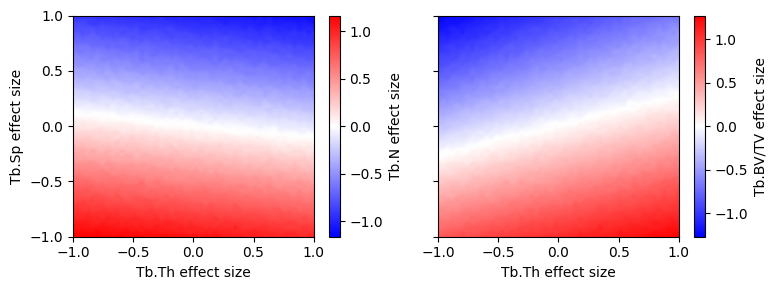

In [15]:
color_levels = 256

fig, axs = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)

norm = plt.Normalize(-np.abs(tbn_effect_sizes).max(), np.abs(tbn_effect_sizes).max())
axs[0].contourf(
    tbth_effect_sizes,
    tbsp_effect_sizes,
    tbn_effect_sizes,
    cmap="bwr",
    norm=norm,
    levels=color_levels
)
sm = plt.cm.ScalarMappable(norm=norm, cmap="bwr")
cbar = fig.colorbar(sm, ax=axs[0], orientation='vertical', label="Tb.N effect size") 
axs[0].set_ylabel("Tb.Sp effect size")


norm = plt.Normalize(-np.abs(tbbvtv_effect_sizes).max(), np.abs(tbbvtv_effect_sizes).max())
axs[1].contourf(
    tbth_effect_sizes,
    tbsp_effect_sizes,
    tbbvtv_effect_sizes,
    cmap="bwr",
    norm=norm,
    levels=color_levels
)
sm = plt.cm.ScalarMappable(norm=norm, cmap="bwr")
cbar = fig.colorbar(sm, ax=axs[1], orientation='vertical', label="Tb.BV/TV effect size") 

for ax in axs:
    #ax.axis("equal")
    ax.set_xlim(tbth_effect_size_range)
    ax.set_ylim(tbsp_effect_size_range)
    ax.set_xlabel("Tb.Th effect size")

plt.tight_layout()
plt.show()

Finally, summarize all of the type I and type II error rates in the different cases in a table:

In [16]:
errors

,Variables,FDR Control?,Type I Error Rate,Type II Error Rate
0,Tb.Th,False,0.0463,0.20090
1,"Tb.Th, Tb.Sp",False,0.0970,0.19945
2,"Tb.Th, Tb.Sp",True,0.0488,0.21705
3,"Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV",False,0.1320,0.20005
4,"Tb.Th, Tb.Sp, Tb.N, Tb.BV/TV",True,0.0416,0.25120


The ideal case is to examine a single (primary) variable, and here the type I and type II error rates are as expected. 

With two independent variables (with the same expected effect size), we can apply false discovery rate control to maintain the type I error rate at a slight cost to study power, dropping from ~0.80 to ~0.78. Otherwise our type I error rate is doubled (as we would expect).

With two independent variables and two additional dependent variables, with false discovery rate control type I error rate is over-corrected to 0.04 (from 0.05) while study power drops from ~0.8 to ~0.75. Without false discovery rate control, the type I error rate elevates to 0.13.